<a href="https://colab.research.google.com/github/pradeep-kumar-r/Hate-Speech-detection-from-Tweets/blob/main/Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification of Tweets

The objective of this task is to detect hate speech in tweets. 
For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, we will try to predict if a tweet has racist/sexist content.

In [1]:
# Import necessary modules

import os as os
import datetime as dt
import warnings
warnings.filterwarnings(action='ignore')
import io
from google.colab import files

import pandas as pd
import numpy as np
import re
import string
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
uploaded = files.upload()

Saving train_tweets.csv to train_tweets (1).csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['train_tweets.csv']))
df_copy =  df.copy()

In [5]:
df_copy.shape

(31962, 3)

In [ ]:
df_copy.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df_copy.set_index('id', inplace=True)

In [5]:
df_copy.info()
# No missing values in the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB


In [ ]:
# Exploring the dependent variable (prediction label)
"""
1 - hate speech (7%)
0 - no hate speech
"""

df_copy['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Exploring the data, cleaning the Tweets & Extracting features (We will later modularize this)

Defining UDF to remove any text from a string using regex

In [ ]:
def rmtxt(input_tweet, txt):
    for i in re.findall(txt, input_tweet):
        input_tweet = re.sub(i, '', input_tweet)
    return input_tweet  

Removing Text that references to user tags (@user)

In [ ]:
df_copy['tweet1'] = df_copy['tweet'].apply(lambda x:rmtxt(x, '@[\w]*'))
df_copy[['tweet','tweet1']].head()

,tweet,tweet1
id,,
1,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
2,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
3,bihday your majesty,bihday your majesty
4,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
5,factsguide: society now #motivation,factsguide: society now #motivation


Removing punctuations, special characcters and numerical values

In [ ]:
df_copy['tweet2'] = df_copy['tweet1'].str.replace("[^a-zA-Z#]", " ").apply(lambda x:rmtxt(x, '#'))
df_copy[['tweet','tweet2']].head()

,tweet,tweet2
id,,
1,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
2,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause the...
3,bihday your majesty,bihday your majesty
4,#model i love u take with u all the time in ...,model i love u take with u all the time in u...
5,factsguide: society now #motivation,factsguide society now motivation


Removing Words which are too short (less than 3 charcters may be?)

In [ ]:
df_copy['tweet3'] = df_copy['tweet2'].apply(lambda x: ' '.join([i for i in x.split() if len(i) >=3]))
df_copy[['tweet','tweet3']].head()

,tweet,tweet3
id,,
1,@user when a father is dysfunctional and is s...,when father dysfunctional and selfish drags hi...
2,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit can use cause they don ...
3,bihday your majesty,bihday your majesty
4,#model i love u take with u all the time in ...,model love take with all the time
5,factsguide: society now #motivation,factsguide society now motivation


Removing known english stop words & Tokenizing the text column

In [ ]:
from nltk import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
stopset = set(stopwords.words('english'))
stop_token = lambda twt : [i for i in word_tokenize(twt.lower()) if i not in stopset]

In [ ]:
df_copy['tokentweet'] = df_copy['tweet3'].apply(stop_token)
df_copy[['tweet','tweet3','tokentweet']].head(10)

,tweet,tweet3,tokentweet
id,,,
1,@user when a father is dysfunctional and is s...,when father dysfunctional and selfish drags hi...,"[father, dysfunctional, selfish, drags, kids, ..."
2,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit can use cause they don ...,"[thanks, lyft, credit, use, cause, offer, whee..."
3,bihday your majesty,bihday your majesty,"[bihday, majesty]"
4,#model i love u take with u all the time in ...,model love take with all the time,"[model, love, take, time]"
5,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, motivation]"
6,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before they leav...,"[huge, fan, fare, big, talking, leave, chaos, ..."
7,@user camping tomorrow @user @user @user @use...,camping tomorrow danny,"[camping, tomorrow, danny]"
8,the next school year is the year for exams.ð...,the next school year the year for exams can th...,"[next, school, year, year, exams, think, schoo..."
9,we won!!! love the land!!! #allin #cavs #champ...,won love the land allin cavs champions clevela...,"[love, land, allin, cavs, champions, cleveland..."


Lemmatization

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(lemmatizer.lemmatize(stemmer.stem('waking')))
print(stemmer.stem(lemmatizer.lemmatize('waking')))
print(lemmatizer.lemmatize(stemmer.stem('woke')))
print(stemmer.stem(lemmatizer.lemmatize('woke')))

wake
wake
woke
woke


In [ ]:
df_copy['lemtweet'] = df_copy['tokentweet'].apply(lambda x: [stemmer.stem(lemmatizer.lemmatize(i)) for i in x])
df_copy[['tweet','tokentweet','lemtweet']].head(10)

,tweet,tokentweet,lemtweet
id,,,
1,@user when a father is dysfunctional and is s...,"[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc..."
2,@user @user thanks for #lyft credit i can't us...,"[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc..."
3,bihday your majesty,"[bihday, majesty]","[bihday, majesti]"
4,#model i love u take with u all the time in ...,"[model, love, take, time]","[model, love, take, time]"
5,factsguide: society now #motivation,"[factsguide, society, motivation]","[factsguid, societi, motiv]"
6,[2/2] huge fan fare and big talking before the...,"[huge, fan, fare, big, talking, leave, chaos, ...","[huge, fan, fare, big, talk, leav, chao, pay, ..."
7,@user camping tomorrow @user @user @user @use...,"[camping, tomorrow, danny]","[camp, tomorrow, danni]"
8,the next school year is the year for exams.ð...,"[next, school, year, year, exams, think, schoo...","[next, school, year, year, exam, think, school..."
9,we won!!! love the land!!! #allin #cavs #champ...,"[love, land, allin, cavs, champions, cleveland...","[love, land, allin, cav, champion, cleveland, ..."


In [ ]:
# Consolidating the tokens back
df_copy['lemtweet_join'] = df_copy['lemtweet'].apply(lambda x: ' '.join([i for i in x]))
df_copy[['tweet','lemtweet','lemtweet_join']].head()

,tweet,lemtweet,lemtweet_join
id,,,
1,@user when a father is dysfunctional and is s...,"[father, dysfunct, selfish, drag, kid, dysfunc...",father dysfunct selfish drag kid dysfunct run
2,@user @user thanks for #lyft credit i can't us...,"[thank, lyft, credit, use, caus, offer, wheelc...",thank lyft credit use caus offer wheelchair va...
3,bihday your majesty,"[bihday, majesti]",bihday majesti
4,#model i love u take with u all the time in ...,"[model, love, take, time]",model love take time
5,factsguide: society now #motivation,"[factsguid, societi, motiv]",factsguid societi motiv


Visualization - Word Cloud

In [ ]:
word_list = ' '.join([x for x in df_copy['lemtweet_join']])
word_list

'father dysfunct selfish drag kid dysfunct run thank lyft credit use caus offer wheelchair van pdx disapoint getthank bihday majesti model love take time factsguid societi motiv huge fan fare big talk leav chao pay disput get allshowandnogo camp tomorrow danni next school year year exam think school exam hate imagin actorslif revolutionschool girl love land allin cav champion cleveland clevelandcavali welcom ireland consum price index mom climb previou may blog silver gold forex selfish orlando standwithorlando pulseshoot orlandoshoot biggerproblem selfish heabreak valu love get see daddi today day gettingf cnn call michigan middl school build wall chant tcot comment australia opkillingbay seashepherd helpcovedolphin thecov helpcovedolphin ouch junior angri got junior yugyoem omg thank paner thank posit retweet agre friday smile around via user cooki make peopl know essenti oil made chemic euro peopl blame conced goal fat rooney gave away free kick know bale hit sad littl dude badday c

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, random_state=42).generate(word_list)

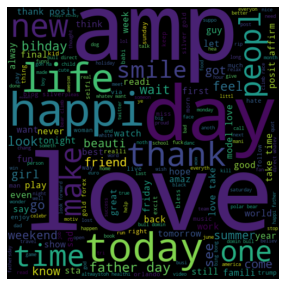

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

WordCloud for toxic tweets


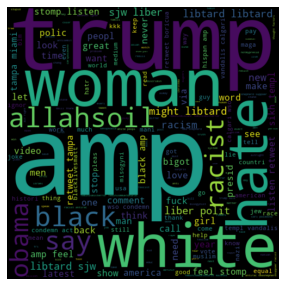

In [ ]:
# Plotting the wordcloud for just the tweets labeled as 1 (racist/sexist)

df_temp = df_copy[df_copy['label'] == 1]
word_list_1 = ' '.join([x for x in df_temp['lemtweet_join']])
wc_1 = WordCloud(width=500, height=500, random_state=42).generate(word_list_1)
plt.figure(figsize=(5, 5))
plt.imshow(wc_1, interpolation="bilinear")
plt.axis('off')
print('WordCloud for toxic tweets')
plt.show()

WordCloud for non-toxic tweets


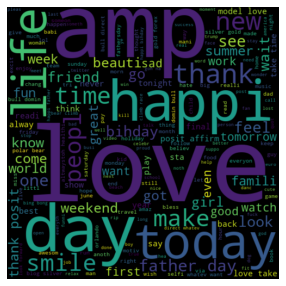

In [ ]:
# Plotting the wordcloud for just the tweets labeled as 0 (non-racist/sexist)

df_temp = df_copy[df_copy['label'] == 0]
word_list_0 = ' '.join([x for x in df_temp['lemtweet_join']])
wc_0 = WordCloud(width=500, height=500, random_state=42).generate(word_list_0)
plt.figure(figsize=(5, 5))
plt.imshow(wc_0, interpolation="bilinear")
plt.axis('off')
print('WordCloud for non-toxic tweets')
plt.show()

Modularizing the entire data processing step

In [7]:
# Writing a UDF that takes test/train as input, does all the pre-processing steps
# and returns the new test/train datasets with the features created

def data_clean(inputser):
    
    def rmtxt(input_tweet, txt):
        for i in re.findall(txt, input_tweet):
            input_tweet = re.sub(i, '', input_tweet)
        return input_tweet  
    
    # Removing User tags
    ser1 = inputser.apply(lambda x:rmtxt(x, '@[\w]*'))
    
    # Removing Special characters
    ser2 = ser1.str.replace("[^a-zA-Z#]", " ").apply(lambda x:rmtxt(x, '#'))
    
    # Removing words that are too short
    ser3 = ser2.apply(lambda x: ' '.join([i for i in x.split() if len(i) >=3]))
    
    # Tokenization
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    nltk.download('punkt')
    stopset = set(stopwords.words('english'))
    stop_token = lambda twt : [i for i in word_tokenize(twt.lower()) if i not in stopset]
    ser4 = ser3.apply(stop_token)

    # Stemming & Lemmatization
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    ser5 = ser4.apply(lambda x: [stemmer.stem(lemmatizer.lemmatize(i)) for i in x])
	
    # Consolidating the tokens back
    ser6 = ser5.apply(lambda x: ' '.join([i for i in x]))
		
    return ser6

Generate Word Embeddings (vectorize the text in a form which the machine can understand) 

First we'll use Bag of Words (BOW) and a simple LR/NB classifier for our benchmark

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# total words 
len(word_list)

1530916

In [ ]:
# length of corpus
df_copy.shape[0]

31962

In [ ]:
bowvec = CountVectorizer(max_df=0.90, min_df=50, max_features=10000, stop_words='english')
bow = bowvec.fit_transform(df_copy['lemtweet_join'])

Build a LR Classifier with this

In [ ]:
print(bow.shape)

(31962, 718)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Train/Test split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow, df_copy['label'], random_state=42, test_size=0.2)

#Define LR Model Class & run Fit method
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train) 

# Predictions On Test data
pred_proba_lr_bow = lr_bow.predict_proba(X_test_bow)

# Set decision threshold as 10% because we saw that only 7% tweets in the ovl dataset were hate speech
pred_lr_bow = (pred_proba_lr_bow[:,1] >= 0.1 ).astype(np.int)

# Computing F1 score (harmonic mean of precision & recall)
f1_score(y_test, pred_lr_bow)

0.4278787878787879

F-1 score of 43% is below par but let's have this as our benchmark and try out other techniques/algos

Let's try a NB classifier on BOW itself to see if there's a lift

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Train/Test split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(bow, df_copy['label'], random_state=42, test_size=0.2)

#Define LR Model Class & run Fit method
nb_bow = GaussianNB()
nb_bow.fit(X_train_bow.toarray(), y_train) 

# Predictions On Test data
pred_proba_nb_bow = nb_bow.predict_proba(X_test_bow.toarray())

# Set decision threshold as 10% because we saw that only 7% tweets in the ovl dataset were hate speech
pred_nb_bow = (pred_proba_nb_bow[:,1] >= 0.1 ).astype(np.int)

# Computing F1 score (harmonic mean of precision & recall)
f1_score(y_test, pred_nb_bow)

0.20464679652663692

This is even worse

Next we'll use TF-IDF with the same two classifiers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidfvec = TfidfVectorizer(max_df=0.90, min_df=10, max_features=10000, stop_words='english')
tfidf = tfidfvec.fit_transform(df_copy['lemtweet_join'])

In [ ]:
tfidf.shape

(31962, 2763)

Build a LR Classifier with this

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Train/Test split
X_train_tf, X_test_tf, y_train, y_test = train_test_split(tfidf, df_copy['label'], random_state=42, test_size=0.2)

#Define LR Model Class & run Fit method
lr_tf = LogisticRegression()
lr_tf.fit(X_train_tf, y_train) 

# Predictions On Test data
pred_proba_lr_tf = lr_tf.predict_proba(X_test_tf)

# Set decision threshold as 10% because we saw that only 7% tweets in the ovl dataset were hate speech
pred_lr_tf = (pred_proba_lr_tf[:,1] >= 0.1 ).astype(np.int)

# Computing F1 score (harmonic mean of precision & recall)
f1_score(y_test, pred_lr_tf)

0.5580715850986121

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, (pred_proba_lr_tf[:,1] >= 0. ).astype(np.int))

0.6445012787723785

Can play around with the decision threshold to get the optimal F-1 score. For e.g

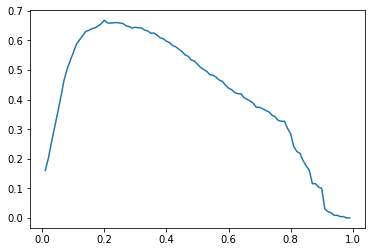

Optimum threshold: 0.2 Optimum F-1 Score: 0.6681175190424375


In [ ]:
thrs = np.arange(0.01,1,0.01)
f1_arr = []

for i in thrs:
    f1_arr.append(f1_score(y_test, (pred_proba_lr_tf[:,1] >= i ).astype(np.int)))

plt.plot(thrs, f1_arr)
plt.show()

# Finding the optima
opt_thrs = thrs[np.argmax(f1_arr)]
print("Optimum threshold: {} Optimum F-1 Score: {}".format(opt_thrs, max(f1_arr)))

F-1 score of 66% is pretty good but let's try out other techniques/algos to see if we can get an improvement

Let's try a Non-Linear Tree based classifier on TF-IDF just in case

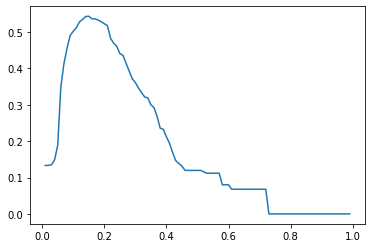

Optimum threshold: 0.15000000000000002 Optimum F-1 Score: 0.5432098765432097


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Train/Test split
X_train_tf, X_test_tf, y_train, y_test = train_test_split(tfidf, df_copy['label'], random_state=42, test_size=0.2)

#Define NB Model Class & run Fit method
rf_tf = RandomForestClassifier(n_estimators=250, 
                               criterion='gini', 
                               max_depth=25, 
                               min_samples_split=64, 
                               min_samples_leaf=16, 
                               max_features='auto', 
                               random_state=42)

rf_tf.fit(X_train_tf, y_train) 

# Predictions On Test data
pred_proba_rf_tf = rf_tf.predict_proba(X_test_tf)

# Finding the optimum decision theshold & the f-1 score
thrs = np.arange(0.01,1,0.01)
f1_arr = []

for i in thrs:
    f1_arr.append(f1_score(y_test, (pred_proba_rf_tf[:,1] >= i ).astype(np.int)))

plt.plot(thrs, f1_arr)
plt.show()

# Finding the optima
opt_thrs = thrs[np.argmax(f1_arr)]
print("Optimum threshold: {} Optimum F-1 Score: {}".format(opt_thrs, max(f1_arr)))

This is not that bad but still well below our simplistic LR model

We've tried a simple BOW & TF-IDF embeddings. Note that:
*   There are many other techniques including N-grams, skip grams which try to address certain shortcomings of simple embeddings.
*   Similarly, we've tried a Logistic Regression, Gaussian Naive Bayes & Random Forest classifiers only without even tuning the model hyper parameters. There are ways to fine-tune these hyperparameters to boost performance & also plenty of other techniques we can try.

The goal here (as mentioned at the start) is not to obtain the best result but to go on a simple exploratory journey of solving this text classification problem using different basic techniques


Modularizing the entire data processing step

In [8]:
# Writing a UDF that takes test/train as input, does all the pre-processing steps
# and returns the new test/train datasets with the features created

def data_clean(inputser):
    
    def rmtxt(input_tweet, txt):
        for i in re.findall(txt, input_tweet):
            input_tweet = re.sub(i, '', input_tweet)
        return input_tweet  
    
    # Removing User tags
    ser1 = inputser.apply(lambda x:rmtxt(x, '@[\w]*'))
    
    # Removing Special characters
    ser2 = ser1.str.replace("[^a-zA-Z#]", " ").apply(lambda x:rmtxt(x, '#'))
    
    # Removing words that are too short
    ser3 = ser2.apply(lambda x: ' '.join([i for i in x.split() if len(i) >=3]))
    
    # Tokenization
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    nltk.download('punkt')
    stopset = set(stopwords.words('english'))
    stop_token = lambda twt : [i for i in word_tokenize(twt.lower()) if i not in stopset]
    ser4 = ser3.apply(stop_token)

    # Stemming & Lemmatization
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    ser5 = ser4.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
	
    # Consolidating the tokens back
    ser6 = ser5.apply(lambda x: ' '.join([i for i in x]))
		
    return ser6

In [9]:
df_copy['lemtweet_join'] = data_clean(df_copy['tweet'])
df_copy.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,label,tweet,lemtweet_join
id,,,
1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
3,0,bihday your majesty,bihday majesty
4,0,#model i love u take with u all the time in ...,model love take time
5,0,factsguide: society now #motivation,factsguide society motivation


Let's now move to more sophisticated techniques - both in terms of embeddings (word2vec, custom embedding) & also in terms of algos (neural networks - FFN, RRNs and possibly even transformers)

In [ ]:
from tqdm import tqdm
from gensim.models import Word2Vec

In [ ]:
# train word2vec model
w2v = Word2Vec(size = 150,
               sg=1,
               window=10,
               seed = 42)

In [ ]:
# length of the vocab
len(w2v.wv.vocab)

0

In [ ]:
tweets = df_copy['lemtweet_join'].apply(lambda x: x.split())
w2v.build_vocab(list(tweets))

In [ ]:
# length of the vocab
len(w2v.wv.vocab)

5595

In [ ]:
w2v.train(list(tweets), total_words = w2v.corpus_count, epochs=25, report_delay=1)

(18346508, 23718400)

In [ ]:
print(w2v)

Word2Vec(vocab=5595, size=150, alpha=0.025)


In [ ]:
# Check similarity between intuitive similar words
print(w2v.similarity('man','woman'))
print(w2v.similarity('animal','woman'))
print(w2v.similarity('pen','woman'))
print(w2v.similarity('queen','king'))
print(w2v.similarity('boy','man'))

0.23124412
0.1670408
-0.02016695
0.3351942
0.31500617


Using tensor flow, let's build a simple FFN to predict sentiment

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df_copy['lemtweet_join'], df_copy['label'], random_state=42, test_size=0.2)
X_train1 = X_train.apply(lambda x:x.split())
X_test1 = X_test.apply(lambda x:x.split())

In [ ]:
X_train1[0]

['father', 'dysfunctional', 'selfish', 'drag', 'kid', 'dysfunction', 'run']

In [ ]:
# Defining UDF to scan through a document & return the averaged w2v embedding across the document
def buildWordVector(tokens, size, word2vecmodel):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += word2vecmodel[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
buildWordVector(['father', 'dysfunctional', 'selfish', 'drag', 'kid', 'dysfunction', 'run'], 150, w2v).shape

(1, 150)

In [ ]:
buildWordVector(['father', 'selfish', 'beat', 'kid', 'daily'], 150, w2v).shape

(1, 150)

In [ ]:
# Applying the function on our train/test data & also scaling the vector to have mean=0 & std=1
X_train_w2v = np.concatenate([buildWordVector(x, 150, w2v) for x in X_train1])
X_test_w2v = np.concatenate([buildWordVector(x, 150, w2v) for x in X_test1])
X_train_w2v.shape , X_test_w2v.shape

((25569, 150), (6393, 150))

In [ ]:
# Scaling the inputs because usually scaled features help in faster convergence
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
X_train_w2v_sc = stdscaler.fit_transform(X_train_w2v)
X_test_w2v_sc = stdscaler.transform(X_test_w2v)

In [ ]:
print("# features: {}".format(X_train_w2v_sc.shape[1]))

# features: 150


Defining the architecture of a simple FFN

In [ ]:
ffn_model = tf.keras.models.Sequential()
ffn_model.add(Dense(64, activation='relu', input_dim = X_train_w2v_sc.shape[1]))
ffn_model.add(Dense(32, activation='relu'))
ffn_model.add(Dense(16, activation = 'relu'))
ffn_model.add(Dense(1, activation = 'sigmoid'))

ffn_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
print(ffn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 64)                9664      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 32)                2080      
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 16)                528       
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 1)                 17        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
None


Training the model

In [ ]:
ffn_model.fit(X_train_w2v_sc, y_train, batch_size = 32, epochs = 20, verbose = 1)

Epoch 1/20
800/800 [==============================] - 6s 3ms/step - loss: 0.1599 - precision: 0.6507 - recall: 0.4255
Epoch 2/20
800/800 [==============================] - 2s 3ms/step - loss: 0.1122 - precision: 0.8217 - recall: 0.5806
Epoch 3/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0935 - precision: 0.8509 - recall: 0.6327
Epoch 4/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0791 - precision: 0.8792 - recall: 0.6971
Epoch 5/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0639 - precision: 0.8989 - recall: 0.7620
Epoch 6/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0518 - precision: 0.9193 - recall: 0.8169
Epoch 7/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0406 - precision: 0.9298 - recall: 0.8600
Epoch 8/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0346 - precision: 0.9424 - recall: 0.8880
Epoch 9/20
800/800 [==============================] - 2s

Predictions on Test Data & finding the optimum decision threshold & f1 score

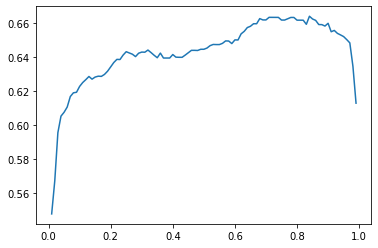

Optimum threshold: 0.8400000000000001 Optimum F-1 Score: 0.6642512077294686


In [ ]:
pred_proba_ann_w2v = ffn_model.predict_proba(X_test_w2v_sc)

# Finding the optimum decision theshold & the f-1 score
thrs = np.arange(0.01,1,0.01)
f1_arr = []

for i in thrs:
    f1_arr.append(f1_score(y_test, (pred_proba_ann_w2v[:,0] >= i ).astype(np.int)))

plt.plot(thrs, f1_arr)
plt.show()

# Finding the optima
opt_thrs = thrs[np.argmax(f1_arr)]
print("Optimum threshold: {} Optimum F-1 Score: {}".format(opt_thrs, max(f1_arr)))

Great, we get almost the best f1 score using a very simple ANN with an arbitrary architecture and no fine tuning whatsoever

## **Now, for the final time....let's try a more sophisticated NN architecture that's designed to handle sequential & text data well - lstms**

In [1]:
# Import necessary modules

import os as os
import datetime as dt
import warnings
warnings.filterwarnings(action='ignore')
import io
from google.colab import files

import pandas as pd
import numpy as np
import re
import string
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
uploaded = files.upload()

Saving train_tweets.csv to train_tweets (5).csv


In [3]:
# Writing a UDF that takes test/train as input, does all the pre-processing steps
# and returns the new test/train datasets with the features created

def data_clean(inputser):
    
    def rmtxt(input_tweet, txt):
        for i in re.findall(txt, input_tweet):
            input_tweet = re.sub(i, '', input_tweet)
        return input_tweet  
    
    # Removing User tags
    ser1 = inputser.apply(lambda x:rmtxt(x, '@[\w]*'))
    
    # Removing Special characters
    ser2 = ser1.str.replace("[^a-zA-Z#]", " ").apply(lambda x:rmtxt(x, '#'))
    
    # Removing words that are too short
    ser3 = ser2.apply(lambda x: ' '.join([i for i in x.split() if len(i) >=3]))
    
    # Tokenization
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    nltk.download('punkt')
    stopset = set(stopwords.words('english'))
    stop_token = lambda twt : [i for i in word_tokenize(twt.lower()) if i not in stopset]
    ser4 = ser3.apply(stop_token)

    # Stemming & Lemmatization
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    ser5 = ser4.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
	
    # Consolidating the tokens back
    ser6 = ser5.apply(lambda x: ' '.join([i for i in x]))
		
    return ser6

In [4]:
df = pd.read_csv(io.BytesIO(uploaded['train_tweets.csv']))
df_copy =  df.copy()
df_copy.set_index('id', inplace=True)
df_copy['lemtweet_join'] = data_clean(df_copy['tweet'])
df_copy.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,tweet,lemtweet_join
id,,,
1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
3,0,bihday your majesty,bihday majesty
4,0,#model i love u take with u all the time in ...,model love take time
5,0,factsguide: society now #motivation,factsguide society motivation


Define model architechture parameters

In [5]:
# Define architecture parameters
embedding_dimension = 64        # dimension of the embedding space (each word is represented as a vector of what length) / will also be out Input dimension
max_sequence_length = 20        # maximum sequence length
lstm_units = 64                 # num of lstm cells in hidden layer
batch_size = 32                 # how many tweets are parsed at a given time and are used for gradient descent
num_classes = 2                 # num of output classes (binary - hate speech/not hate speech)
out_dim = 1                     # Output dimension

Convert the text sequence into numeric using word2vec again

In [6]:
from gensim.models import Word2Vec

# train word2vec model
w2v = Word2Vec(size = embedding_dimension,
               sg=1,
               window=5,
               seed = 42)

tweets = df_copy['lemtweet_join'].apply(lambda x: x.split())
w2v.build_vocab(list(tweets))

# length of the vocab
print(len(w2v.wv.vocab))

# train the embedding
w2v.train(list(tweets), total_words = w2v.corpus_count, epochs=25, report_delay=1)

print(w2v)

5595
Word2Vec(vocab=5595, size=64, alpha=0.025)


In [7]:
# Defining UDF to scan through a document & return the averaged w2v embedding across the document
def buildWordVector(tokens, size, word2vecmodel):
    vec = []
    length = 0
    for word in tokens:
        try:
            vec.append(word2vecmodel[word])
            length += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    vec = np.array(vec).reshape((1, len(vec), size))
    return vec, length

Using tensor flow, let's build an lstm network to predict sentiment

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Embedding, Input, merge
print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.5.0


In [9]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df_copy['lemtweet_join'], df_copy['label'], random_state=42, test_size=0.2)
X_train = X_train.apply(lambda x:x.split())
X_test = X_test.apply(lambda x:x.split())

In [10]:
X_train_w2v = X_train.apply(lambda x: buildWordVector(x, embedding_dimension, w2v)[0])
seq_len_train = X_train.apply(lambda x: buildWordVector(x, embedding_dimension, w2v)[1])

X_test_w2v = X_test.apply(lambda x: buildWordVector(x, embedding_dimension, w2v)[0])
seq_len_test = X_test.apply(lambda x: buildWordVector(x, embedding_dimension, w2v)[1])

In [11]:
seq_len_train = np.array(seq_len_train)
seq_len_test = np.array(seq_len_test)

Padding & truncating sequencessequences

In [12]:
X_train_w2v_pd = np.zeros((len(X_train_w2v), max_sequence_length, embedding_dimension))

for i, j in enumerate(X_train_w2v):
    if j.shape[1] <= 20:
        X_train_w2v_pd[i, :j.shape[1], :] = j[0]
    else:
        X_train_w2v_pd[i, :20, :] = j[0][:20]

In [13]:
X_test_w2v_pd = np.zeros((len(X_test_w2v), max_sequence_length, embedding_dimension))

for i, j in enumerate(X_test_w2v):
    if j.shape[1] <= 20:
        X_test_w2v_pd[i, :j.shape[1], :] = j[0]
    else:
        X_test_w2v_pd[i, :20, :] = j[0][:20]

In [14]:
y_train = np.array(y_train).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))

seq_len_train = seq_len_train.flatten()
seq_len_test = seq_len_test.flatten()

In [15]:
print(X_train_w2v_pd.shape)
print(seq_len_train.shape)
print(y_train.shape)

print(X_test_w2v_pd.shape)
print(seq_len_test.shape)
print(y_test.shape)

(25569, 20, 64)
(25569,)
(25569, 1)
(6393, 20, 64)
(6393,)
(6393, 1)


Helper functions for various purposes

In [22]:
# Define hyper-parameters
learning_rate = 0.0005            # step size/learning rate (function of how much the model will learn in each loss optimization step)
num_iterations = 1000           # num steps of optimization / epochs
display_freq = 100              # display model status once in how many steps

In [17]:
# To carve out next training batch
def next_batch(x, y, seq_len, batch_size):
    N = x.shape[0]
    batch_indeces = np.random.permutation(N)[:batch_size]
    x_batch = x[batch_indeces]
    y_batch = y[batch_indeces]
    seq_len_batch = seq_len[batch_indeces]
    return x_batch, y_batch, seq_len_batch

In [18]:
# Placeholders for inputs(x), input sequence lengths (seqLen) and outputs(y)
X = tf.placeholder(tf.float32, [None, None, embedding_dimension])
seqLen = tf.placeholder(tf.int32, [None])
y = tf.placeholder(tf.float32, [None, 1])

In [19]:
# create all weight matrices initialized randomly from a normal distribution ~N(0, 0.1) && bias vectors initialized as a small value = 0.1
W = tf.get_variable('W',
                    dtype=tf.float32,
                    shape=[lstm_units, num_classes],
                    initializer=tf.truncated_normal_initializer(stddev=0.1))

b = tf.get_variable('b',
                    dtype=tf.float32,
                    initializer=tf.constant(0.1, shape=[num_classes], dtype=tf.float32))

In [20]:
# Define the core LSTM functionality & build the network - define the operations that happen in the computational graph

LSTM_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_units)
wrapped_LSTM_cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell=LSTM_cell, output_keep_prob=0.8)
rnn_output, rnn_state = tf.nn.dynamic_rnn(wrapped_LSTM_cell, X, sequence_length=seqLen, dtype=tf.float32)
# output = tf.transpose(rnn_output, [1, 0, 2])

index = tf.range(0, tf.shape(rnn_output)[0]) * max_sequence_length + (seqLen - 1)
lastout = tf.gather(tf.reshape(rnn_output, [-1, lstm_units]), index)

# lastout = tf.gather((output, seqLen - 1)

# lastout = tf.gather(output, - 1)
pred = tf.matmul(lastout, W) + b
W = tf.cast(W, tf.float64)
lastout = tf.cast(lastout, tf.float64)
b = tf.cast(b, tf.float64)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
# Define the loss function (i.e. binary cross entropy) and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
train_oper = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [25]:
# Creating the op for initializing all variables
init = tf.global_variables_initializer()

Training the model (running the compiled graph in a tf session) & also predictions on the test set

In [26]:
with tf.Session() as sess:
    sess.run(init)
    print('----------Training---------')
    for i in range(num_iterations):
        X_batch, y_batch, seq_len_batch = next_batch(X_train_w2v_pd, y_train, seq_len_train, batch_size)
        _, bce_loss = sess.run([train_oper, cost], feed_dict={X: X_batch, y: y_batch, seqLen: seq_len_batch})
        if (i+1) % display_freq == 0:
            print('Step {0:<4}, TRAINING Loss={1:.4f}'.format(i, bce_loss))
    pred_lstm_w2v_train = sess.run(pred, feed_dict={X: X_train_w2v_pd, seqLen: seq_len_train})
    pred_lstm_w2v = sess.run(pred, feed_dict={X: X_test_w2v_pd, seqLen: seq_len_test})

----------Training---------
Step 99  , TRAINING Loss=0.1343
Step 199 , TRAINING Loss=0.0439
Step 299 , TRAINING Loss=0.1323
Step 399 , TRAINING Loss=0.1782
Step 499 , TRAINING Loss=0.0474
Step 599 , TRAINING Loss=0.2727
Step 699 , TRAINING Loss=0.0866
Step 799 , TRAINING Loss=0.1336
Step 899 , TRAINING Loss=0.0000
Step 999 , TRAINING Loss=0.2187


In [27]:
pred_lstm_w2v_train, pred_lstm_w2v

(array([[-37.545914, -37.73055 ],
        [-40.135654, -40.838146],
        [-40.368847, -40.63871 ],
        ...,
        [-37.149963, -36.843956],
        [-40.048462, -39.564484],
        [-37.04797 , -37.44018 ]], dtype=float32),
 array([[-35.217175, -34.95872 ],
        [-39.525455, -39.710953],
        [-36.02912 , -37.168278],
        ...,
        [-36.163193, -37.08487 ],
        [-36.776577, -37.110226],
        [-37.36061 , -37.52454 ]], dtype=float32))

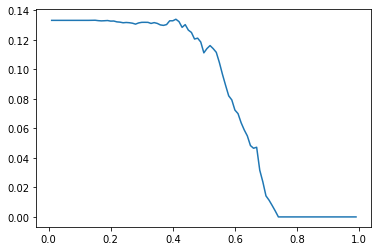

Optimum threshold: 0.41000000000000003 Optimum F-1 Score: 0.13391304347826088


In [30]:
# we won't be able to extract the raw probabilities directly - instead we have to apply the softmax formula
from sklearn.metrics import confusion_matrix, f1_score
import math

pred_proba_lstm_w2v_train = (math.e ** pred_lstm_w2v_train[:, 1]) / ((math.e ** pred_lstm_w2v_train[:, 0]) + (math.e ** pred_lstm_w2v_train[:, 1]))
pred_proba_lstm_w2v = (math.e ** pred_lstm_w2v[:, 1]) / ((math.e ** pred_lstm_w2v[:, 0]) + (math.e ** pred_lstm_w2v[:, 1]))

# Finding the optimum decision theshold & the f-1 score
thrs = np.arange(0.01,1,0.01)
f1_arr = []

for i in thrs:
    f1_arr.append(f1_score(y_test, (pred_proba_lstm_w2v >= i ).astype(np.int)))

plt.plot(thrs, f1_arr)
plt.show()

# Finding the optima
opt_thrs = thrs[np.argmax(f1_arr)]
print("Optimum threshold: {} Optimum F-1 Score: {}".format(opt_thrs, max(f1_arr)))

Really bad F-1 score. Probably because one of precision/recall went for a toss since we didn't do much pre-processing or train a good embedding or go for deeper architectures where the model could learn non-linear complex relationships 

**The focus is not on the model performance, rather to show how to process free flowing text into machine-readable forms and how to apply different ML algorithms to solve the problem at hand.**